# Constrained MPC
---
This is just to test MPC so as to implement it back into DrivePointMPC.ipynb

In [0]:
import numpy as np
import scipy
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.linalg import expm
import matplotlib.pyplot as plt

# Model Predictive Control
---

$$ Minimize \hspace{1cm} J(\Delta U)=Y^TQY+\Delta U^TR\Delta U $$
$$ s.t.:\hspace{1cm} |U|\leq 0.5 rads$$
$$\hspace{2cm} |\Delta U|\leq 0.1 rads$$


In [0]:
class MPC:
  def __init__(self,L,h,Np,Q,R):
    self.L=L
    self.h=h
    self.Np=Np
    diagQ=np.kron(np.eye(self.Np),Q)
    diagR=np.kron(np.eye(self.Np),R)
    self.Q=diagQ
    self.R=diagR
  
  def cost(self,du):
    du=du.reshape([self.Np,1])
    return 0.5*((self.ref-self.W.dot(self.xa)-self.Z.dot(du)).T.dot(self.Q).dot(self.ref-self.W.dot(self.xa)-self.Z.dot(du))+du.T.dot(self.R).dot(du))
  
  def constr0(self,du):
    return np.sum(du[:10])+u[0,k-1]+1
  
  def constr1(self,du):
    return -np.sum(du[:10])-u[0,k-1]+1
  
  def constr2(self,du):
    return np.sum(du[10:])+u[1,k-1]+0.5
  
  def constr3(self,du):
    return -np.sum(du[10:])-u[1,k-1]+0.5
  
  def mpcMats(self,Ac,Bc,Cc):
    #Continuous to Discrete Conversion
    #Ac nilpotent of order 2, A=e^AT=I+AT; B=(BT+.5AT^2)
    Ad=np.eye(3)+self.h*Ac
#     Bd=Bc*self.h+0.5*self.h**2*Ac.dot(Bc)
    Bd=Bc.reshape(3,1)*self.h+0.5*self.h**2*Ac.dot(Bc.reshape(3,1))
    Cd=Cc
    n=len(Ad)#of states
    m=1
#     m=len(Bd[0])# num of inputs
    p=len(Cd)#of outputs
    
    PhiA=np.block([[Ad,np.zeros([n,p])],[Cd.dot(Ad),np.eye(p)]])
    GammaA=np.block([[Bd],[Cd.dot(Bd)]])
    Ca=np.block([np.zeros([p,n]),np.eye(p)])
    W=np.zeros([self.Np*p,n+p],dtype="float64")
    Z=np.zeros([self.Np*p,self.Np*m],dtype="float64")
    for i in range(1,self.Np+1):
      W[(i-1)*p:i*p][:]=Ca.dot(np.linalg.matrix_power(PhiA,i))
      for j in range(1,self.Np+1):
        if i>=j:
          Z[(i-1)*p:i*p,(j-1)*m:j*m]=(Ca.dot(np.linalg.matrix_power(PhiA,i-j))).dot(GammaA)
        
    return(W,Z,Ca,PhiA,GammaA)
  
  def optimizer(self,xa,A,B,C,R,Q,ref):
    self.xa=xa.reshape([6,1])
    self.W,self.Z,self.Ca,self.PhiA,self.GammaA=mpc.mpcMats(A,B,C)
    self.ref=np.kron(np.ones([self.Np,1]),ref)
    bv=[-.25,.25]
    bgam=[-.125,.125]
    bnds=[#bv,bv,bv,bv,bv,bv,bv,bv,bv,bv,\
          bgam,bgam,bgam,bgam,bgam,bgam,bgam,bgam,bgam,bgam]
    constr=[#{'type':'ineq','fun':self.constr0},\
            #{'type':'ineq','fun':self.constr1},\
            {'type':'ineq','fun':self.constr2},\
            {'type':'ineq','fun':self.constr3}]
#     init=np.concatenate([0.5*np.ones(10,),0.*np.ones(10,)])
    init=np.concatenate([0.*np.ones(10,)])
    dU=minimize(self.cost,init,method='SLSQP',bounds=bnds,constraints=constr)
#     print(dU.x)
    print("solved cost:",self.cost(dU.x))
    return dU.x
  
  def ugvModel(self,x,t,u):
    dx=np.empty(3);
    dx[0]=u[0]*np.cos(x[2]);
    dx[1]=u[0]*np.sin(x[2]);
    dx[2]=u[0]/self.L*np.tan(u[1]);
    
    return dx
  
  def ugvJac(self,x,u):
    A=np.array([[0,0,-u[0]*np.sin(x[2])],[0,0,u[0]*np.cos(x[2])],[0,0,0]]) #STMat Sys1
    B=np.array([[np.cos(x[2]),0],[np.sin(x[2]),0],[1/self.L*np.tan(u[1]),u[0]/self.L/np.cos(u[1])**2]])#ITMat Sys1
    B=B[:,1]
    C=np.eye(3)
    D=[0.]
    return (A,B,C,D)

In [0]:
h=0.1
Np=10 #Length of Prediction Horizon
ploss=0.3 #Probability of lost control signal
closs=0  #Number of consecutive losses (caps at 9)

ref=np.array([3,4,np.pi]).reshape(3,1)
x0=np.array([3.6,0,np.pi/2]).T
u0=np.array([1,0]).T
tspan=[0,20]
xn=np.zeros([3,int(np.ceil(tspan[1]/h+1))])
xn[0:3,0]=x0
xa=np.zeros([6,int(np.ceil(tspan[1]/h+1))])
u=np.kron(np.ones([1,int(np.ceil(tspan[1]/h+1))]),u0.reshape([2,1]))
# R=np.diag([1.,1.])
R=np.diag([0.])
Q=np.diag([4.,4.,0.]) #If I were to impose a cost on theta, it would have to be nonlinear otherwise most initial conditions would throw off the algorithm

mpc=MPC(0.2,h,Np,Q,R)

DU=np.zeros([10,2], dtype='float64')
dU=np.array([0.,0.])

for k in range(1,int(np.ceil(tspan[1]/h+1))):
  
  #Simulate UGVs for iter
  x=integrate.odeint(mpc.ugvModel,xn[:,k-1],np.linspace((k-1)*h,k*h),args=(u[:,k-1],))  
  #Calculate Jacobian for AMPC
  A,B,C,D=mpc.ugvJac(xn[:,k-1],u[:,k-1])
  
  #Value at end of time step
  xn[:,k]=x.T[:,-1]
  xa[:,k]=np.concatenate(((xn[:,k]-xn[:,k-1]),C.dot(xn[:,k])))
  
  
  #C is setup to automatically take the difference of the poses, so r=<0,0,0>
  #r=np.zeros([3,1],dtype="float64")
  event=np.random.rand()
  if event>ploss:
    DU=mpc.optimizer(xa[:,k],A,B,C,R,Q,ref).reshape(1,10).T
    closs=0
    #print("Received")
  else:
    closs+=1
    closs=min(closs,Np-1)
    #print("Dropped")
#   print(DU)
#   dU[0]=np.min([np.max([DU[closs,0],-0.5]),0.5])
#   dU[1]=np.min([np.max([DU[closs,1],-0.1]),0.1])
#   u[0,k]=np.min([np.max([dU[0]+u[0,k-1],-0.5]),1.])
#   u[1,k]=np.min([np.max([dU[1]+u[1,k-1],-0.5]),0.5])
  u[1,k]=DU[closs,0]+u[1,k-1]
#   u[1,k]=DU[closs,1]+u[1,k-1]
#   print("="*30)
  print(xn[0:2,k].reshape([2,1])-ref[0:2,:])
  err=xn[0:2,k].reshape([2,1])-ref[0:2,:]
  if err.T.dot(err)<0.05:
    break
print("Done!",k)


('solved cost:', array([[229.38506911]]))
[[ 0.6]
 [-3.9]]
('solved cost:', array([[215.57243352]]))
[[ 0.59685965]
 [-3.80006579]]
('solved cost:', array([[204.69250285]]))
[[ 0.58423577]
 [-3.70093427]]
[[ 0.55579143]
 [-3.60523328]]
('solved cost:', array([[185.70048607]]))
[[ 0.50984596]
 [-3.51656779]]
('solved cost:', array([[173.15001123]]))
[[ 0.45131501]
 [-3.43555303]]
('solved cost:', array([[158.00249464]]))
[[ 0.38635956]
 [-3.35953483]]
('solved cost:', array([[141.7193425]]))
[[ 0.32004118]
 [-3.28469021]]
('solved cost:', array([[126.29465538]]))
[[ 0.25716277]
 [-3.20696349]]
('solved cost:', array([[115.04100108]]))
[[ 0.2031625 ]
 [-3.12289692]]
('solved cost:', array([[110.53145578]]))
[[ 0.16486515]
 [-3.03072434]]
('solved cost:', array([[110.88015298]]))
[[ 0.15073976]
 [-2.93208236]]
('solved cost:', array([[111.66863416]]))
[[ 0.16813019]
 [-2.83410919]]
[[ 0.21400762]
 [-2.74557003]]
('solved cost:', array([[109.41593657]]))
[[ 0.27836418]
 [-2.66921688]]
('so

(3, 201)
(2, 201)


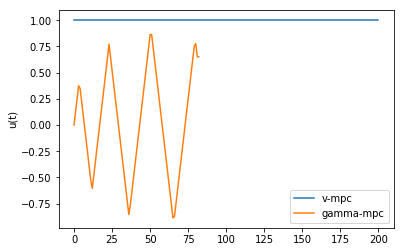

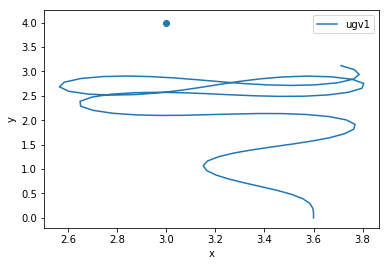

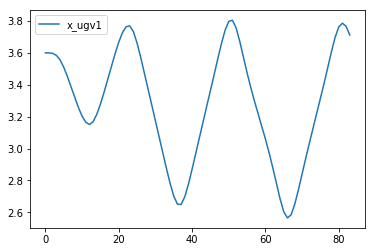

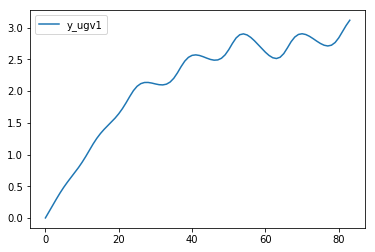

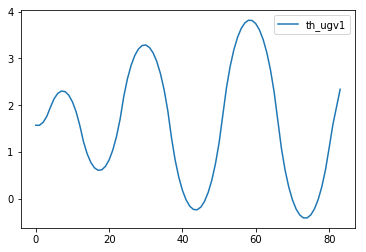

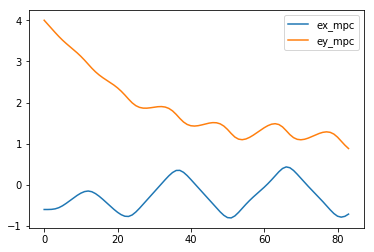

In [0]:
print(xn.shape)
print(u.shape)

#input plot
plt.plot(u[0,:].T,label="v-mpc")
plt.plot(u[1,:].T,label="gamma-mpc")
# plt.xlabel('time')
plt.ylabel('u(t)')
plt.legend()
plt.show()

#xy plot
plt.plot(xn[0,:],xn[1,:],label="ugv1")
plt.scatter(ref[0],ref[1])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#x plot
plt.plot(xn[0,:],label="x_ugv1")
plt.legend()
plt.show()

#y plot
plt.plot(xn[1,:],label="y_ugv1")
plt.legend()
plt.show()

#theta plot
plt.plot(xn[2,:],label="th_ugv1")
plt.legend()
plt.show()

#error plot
plt.plot(ref[0]-xn[0,:],label="ex_mpc")
plt.plot(ref[1]-xn[1,:],label="ey_mpc")
plt.legend()
plt.show()

#derivative plot
# plt.plot(xa[6,:],label="dx")
# plt.plot(xa[7,:],label="dy")
# plt.plot(xa[8,:],label="dtheta")
# plt.legend()
# plt.show()

# plt.plot(xn[3,:-1]-xn[3,1:],label="x2mpc")
# plt.plot(xn2[3,:-1]-xn2[3,1:],label="x2pid")
# plt.show()
#print(xn)



# Discussion
---
It seems to me that MPC has better long-term performance overall, though in the short run, pid vastly outperforms it. I think it is because of the fact that the way, by construction, it can actually account for the heading information $x_3$. In order to include something like that for the MPC it would entail the introduction of a nonlinearity. Or I could make the odeint just return an equivalent sort of thing...

In [0]:
print(xn.shape)
print(xa.shape)
print(np.arctan2(3,4))

(3, 201)
(6, 201)
0.6435011087932844


In [0]:
-0.1 <= x <=0.1

[[ 1.00000000e+00  9.00000000e-01  8.00000000e-01  7.00000000e-01
   6.00000025e-01  5.00000025e-01  4.00000025e-01  3.00000025e-01
   2.00000025e-01  1.00000026e-01  2.57652993e-08             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
          